# Price Impact Analysis (Case: 5bus_nrel)

In this analysis, we want to study the structure of Price Impact / Price formation in electricity markets.

## Dependencies and Data Preparation

#### Packages and Diretory

In [1]:
#make sure it is in "GridAnalysis.jl" cd("..\\..\\..\\")

In [2]:
pwd()

"C:\\Users\\daniele\\Desktop\\Projeto\\GridAnalysis.jl"

In [3]:
using Pkg
Pkg.activate("./examples/5bus_nrel/price_impact_analysis_5bus_nrel")

In [4]:
Pkg.instantiate()

In [5]:
using Logging 
Logging.disable_logging(Logging.Info) #script to disable info messages 
Logging.disable_logging(Logging.Warn) #script to disable warning messages

LogLevel(1001)

In [6]:
using Dates
using DataFrames
using GridAnalysis
using Gurobi
using PowerSystems
using PowerSimulations
using Test
using Measures
using Plots

#### Uploading Utils

Might not work if running lines manually 
(solution: edit to be the path for this examples directory for example: 'example_dir = "./examples/5bus_nrel/"')

In [7]:
example_dir = "./examples/5bus_nrel/"
data_dir = joinpath(example_dir, "data")
include(joinpath(example_dir, "utils.jl"))

load_plot_set_of_simulations

#### Data Prep and Build Market Simulator
define solvers for Unit Commitment (UC), Real Time (RT) and Economic Dispatch (ED)

In [8]:
solver_uc = optimizer_with_attributes(Gurobi.Optimizer)
solver_rt = optimizer_with_attributes(Gurobi.Optimizer)
solver_ed = optimizer_with_attributes(Gurobi.Optimizer)

MathOptInterface.OptimizerWithAttributes(Gurobi.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute, Any}[])

## Define analysis to be done

In [9]:
Network = [DCPPowerModel];
Ramp = [true];
Minimal_generation = [true];
Reserve = [true];
Offer_Bus = ["bus1", "bus2", "bus3", "bus4", "bus5"];
bidding_period = [collect(1:24), [1]];

#### Create a DataFrame where each line represents one analysis 

In [14]:
df = DataFrame(Network = [], 
               Ramp = [],
               Minimal_generation = [],
               Reserve = [],
               Offer_Bus = [],
               bidding_period = []) 

for a in Network 
    for b in Ramp 
        for c in Minimal_generation 
            for d in Reserve
                for e in Offer_Bus
                    for f in bidding_period
                        new_data = DataFrame(Network = [Dict("DA"=>a, "RT"=>a)], 
                        Ramp = [Dict("DA"=>b, "RT"=>b)],
                        Minimal_generation = [Dict("DA"=>c, "RT"=>c)],
                        Reserve = [d],
                        Offer_Bus = [e],
                        bidding_period = [f])
                        append!(df, new_data)
                    end
                end
            end
        end
    end
end
df[!,5:6]

,Offer_Bus,bidding_period
,Any,Any
1,bus1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]"
2,bus1,[1]
3,bus2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]"
4,bus2,[1]
5,bus3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]"
6,bus3,[1]
7,bus4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]"
8,bus4,[1]
9,bus5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]"


#### Define range quota and period to be analysed

In [15]:
range_quota = Float64.(collect(0:0.1:4));
initial_time = Date("2020-01-01");
period_analysed = [5,19];
initial_bidding_time = DateTime("2020-01-01");
path = "results";

## Run all the simulations

In [16]:
run_set_of_simulations(df, data_dir, example_dir, solver_uc, solver_ed, solver_rt,
    range_quota, initial_time, initial_bidding_time, path)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
  Step:                  1
  problem:               RT
  Simulation Timestamp:  2020-01-01T23:55:00


### Locality Impact: What is the impact of the virtual offer as we move away from the offer node? 

Analytics metrics to be used:

1. Price change for nodes connected and nodes not connected to the offer node;
2. Price change according to the distance to the offer node. Where "distance" refers to the number of buses between them;
3. Price change according to the bottleneck between the buses and the offer node. Where "bottleneck" is related to the trasmission lines capacity limits.

##### Load the simulation done previously 

In [17]:
lines=[1,3,5,7,9]
period_analysed=[[5],[19]] 

2-element Vector{Vector{Int64}}:
 [5]
 [19]

In [19]:
graphic = "plot_price_curves"
plt_f = load_plot_set_of_simulations(df, data_dir, example_dir, solver_uc, solver_ed, solver_rt,
        range_quota, initial_time, lines, period_analysed, initial_bidding_time, path, graphic,false)
plt_t = load_plot_set_of_simulations(df, data_dir, example_dir, solver_uc, solver_ed, solver_rt,
        range_quota, initial_time, lines, period_analysed, initial_bidding_time, path, graphic,true)

        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).


5×2 Matrix{Any}:
 Plot{Plots.GRBackend() n=10}  Plot{Plots.GRBackend() n=10}
 Plot{Plots.GRBackend() n=10}  Plot{Plots.GRBackend() n=10}
 Plot{Plots.GRBackend() n=10}  Plot{Plots.GRBackend() n=10}
 Plot{Plots.GRBackend() n=10}  Plot{Plots.GRBackend() n=10}
 Plot{Plots.GRBackend() n=10}  Plot{Plots.GRBackend() n=10}

#### Results

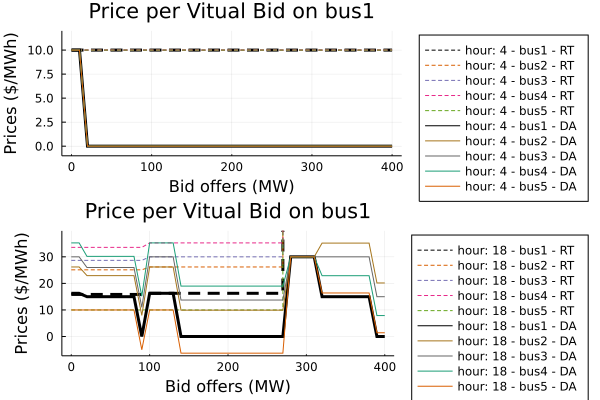

In [26]:
plot(plt_t[1,1],plt_t[1,2],layout=(2,1))

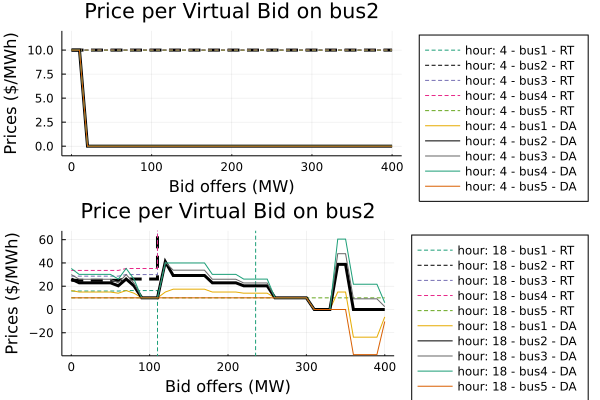

In [27]:
plot(plt_t[2,1],plt_t[2,2],layout=(2,1))

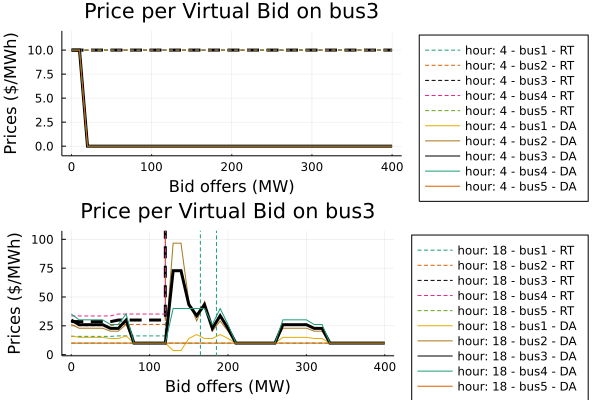

In [29]:
plot(plt_t[3,1],plt_t[3,2],layout=(2,1))

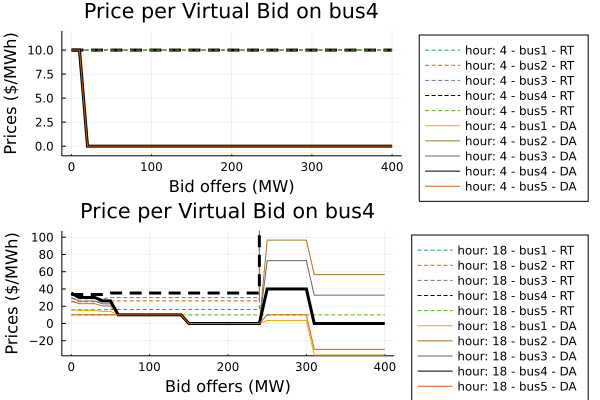

In [30]:
plot(plt_t[4,1],plt_t[4,2],layout=(2,1))

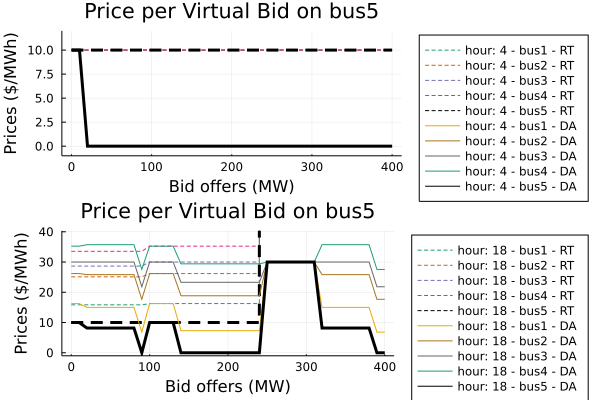

In [31]:
plot(plt_t[5,1],plt_t[5,2],layout=(2,1))

### Hour Impact: What is the impact of the virtual offer as we move away from the offer period?
Proposed evaluation experiment: Make an offer in the first hour and see the impact in the other hours.

#### Load the simulation done previously

In [33]:
lines=[2,4,6,8,10]
period_analysed=[[5],[19]] 

2-element Vector{Vector{Int64}}:
 [5]
 [19]

In [35]:
graphic = "plot_price_curves"
plt_hf = load_plot_set_of_simulations(df, data_dir, example_dir, solver_uc, solver_ed, solver_rt,
        range_quota, initial_time, lines, period_analysed, initial_bidding_time, path, graphic,false)
plt_h = load_plot_set_of_simulations(df, data_dir, example_dir, solver_uc, solver_ed, solver_rt,
        range_quota, initial_time, lines, period_analysed, initial_bidding_time, path, graphic,true)

        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).


5×2 Matrix{Any}:
 Plot{Plots.GRBackend() n=10}  Plot{Plots.GRBackend() n=10}
 Plot{Plots.GRBackend() n=10}  Plot{Plots.GRBackend() n=10}
 Plot{Plots.GRBackend() n=10}  Plot{Plots.GRBackend() n=10}
 Plot{Plots.GRBackend() n=10}  Plot{Plots.GRBackend() n=10}
 Plot{Plots.GRBackend() n=10}  Plot{Plots.GRBackend() n=10}

#### Results

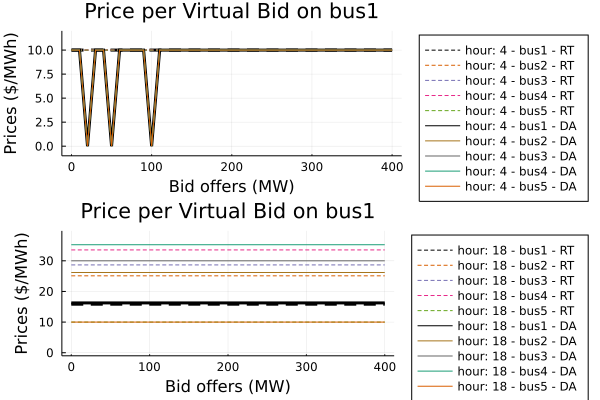

In [36]:
plot(plt_h[1,1],plt_h[1,2],layout=(2,1))

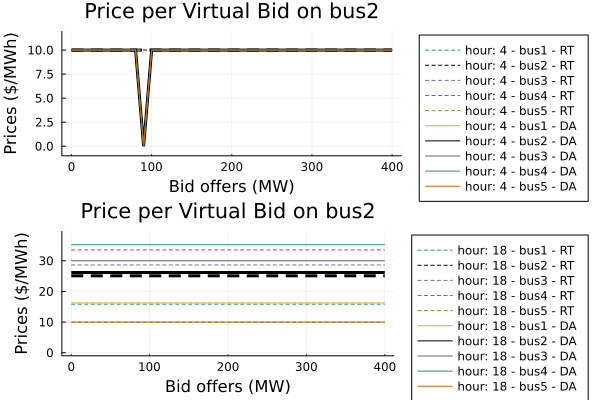

In [37]:
plot(plt_h[2,1],plt_h[2,2],layout=(2,1))

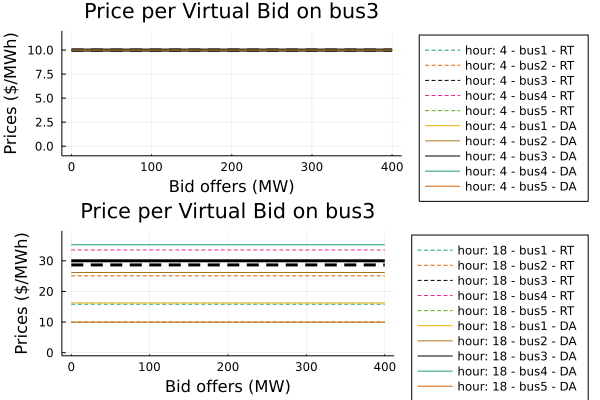

In [38]:
plot(plt_h[3,1],plt_h[3,2],layout=(2,1))

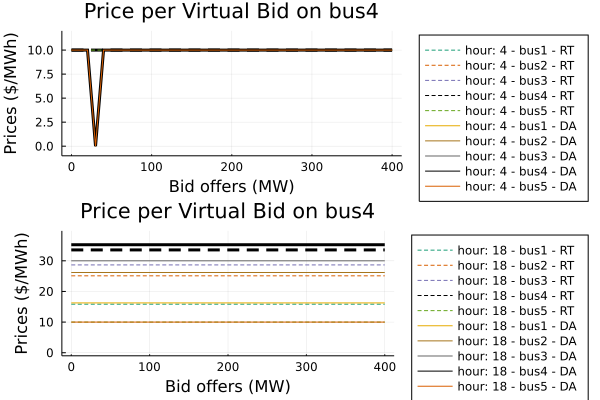

In [39]:
plot(plt_h[4,1],plt_h[4,2],layout=(2,1))

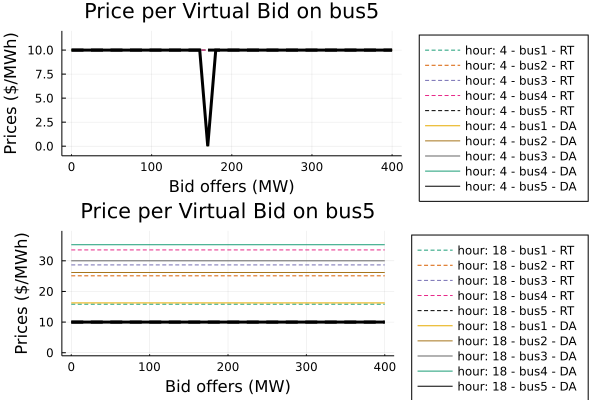

In [40]:
plot(plt_h[5,1],plt_h[5,2],layout=(2,1))